In [2]:
from keras.applications.vgg16 import VGG16

#dense layers inclusas
model = VGG16(weights = 'imagenet')

In [3]:
from keras.preprocessing import image
from keras import utils
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os

img_path = os.getcwd()
img_path = os.path.join(img_path, 'elefantes\elefantes.jpg')

img = utils.load_img(img_path, target_size=(224,224))

x = utils.img_to_array(img)
#Adiciona a dimensão do lote
x = np.expand_dims(x, axis = 0)
# pre-processa o lote
x = preprocess_input(x)

In [3]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 743ms/step
Predicted:  [('n02504458', 'African_elephant', 0.8887968), ('n01871265', 'tusker', 0.102238), ('n02504013', 'Indian_elephant', 0.008635464)]


In [4]:
#index do elefante africano, classe que foi considerada a mais provavel na imagem
np.argmax(preds[0])

386

In [4]:
# Configurando o processo Grad-CAM para determinar as partes da imagem que são mais "elefante africano"-like
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

african_elephant_output = model.output[:, 386]

#feature map da ultima camapa convolucional da VGG16
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis = (0,1,2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *=pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)

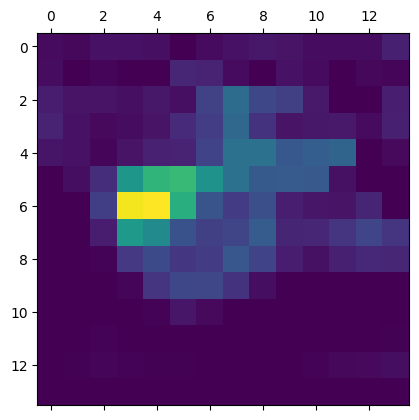

In [5]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [6]:
# Sobrepondo o heatmap e a imagem original
import cv2

img = cv2.imread('elefantes/elefantes.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) #Convert o heatmap para RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elefantes/elefantes_cam.jpg', superimposed_img)

True